## Template Attack - Perform experiments for different train and test sizes. 

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import time

In [2]:
hamming = [bin(n).count("1") for n in range(256)]

traces = np.load(r'C:\Users\seven\PycharmProjects\SymSec\systemssecurity\Lab2\chipwhisperer_data\data\traces.npy')
pt = np.load(r'C:\Users\seven\PycharmProjects\SymSec\systemssecurity\Lab2\chipwhisperer_data\data\plain.npy')
knownkey = np.load(r'C:\Users\seven\PycharmProjects\SymSec\systemssecurity\Lab2\chipwhisperer_data\data\key.npy')

sbox=(
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16) 

def cov(x, y):
    return np.cov(x, y)[0][1]

def train_test_data(traces_size, train_size):
    tracesTrain = traces[0:traces_size]
    ptTrain  = pt[0:traces_size]
    tracesTest = traces[10000-train_size:10000]
    ptTest  = pt[10000-train_size:10000]
    return (tracesTrain, ptTrain, tracesTest, ptTest)


#### The function here is a modification of TA.py 

In [ ]:
def template_attack(test_size, train_size):
    tracesTrain, ptTrain, tracesTest, ptTest = train_test_data(test_size, train_size)

    outputSbox = [sbox[ptTrain[i][0] ^ knownkey[i][0]] for i in range(len(ptTrain))] 
    outputSboxHW   = [hamming[s] for s in outputSbox]

    TracesHW = [[] for _ in range(9)]

    for i in range(len(tracesTrain)):
        HW = outputSboxHW[i]
        TracesHW[HW].append(tracesTrain[i])

    TracesHW = [np.array(TracesHW[HW]) for HW in range(9)]

    Means = np.zeros((9, len(tracesTrain[0])))
    for i in range(9):
        Means[i] = np.average(TracesHW[i], 0)


    SumDiff = np.zeros(len(tracesTrain[0]))
    for i in range(9):
        for j in range(i):
            SumDiff += np.abs(Means[i] - Means[j])


    features = []
    numFeatures = 5
    featureSpacing = 5
    for i in range(numFeatures):
        nextFeature = SumDiff.argmax()
        features.append(nextFeature)

        featureMin = max(0, nextFeature - featureSpacing)
        featureMax = min(nextFeature + featureSpacing, len(SumDiff))
        for j in range(featureMin, featureMax):
            SumDiff[j] = 0

    meanMatrix = np.zeros((9, numFeatures))
    
    """
    Template Attack, the covariance matrix is individually calculated per power trace. 
    """
    covMatrix  = np.zeros((9, numFeatures, numFeatures))
    for HW in range(9):
        for i in range(numFeatures):
            meanMatrix[HW][i] = Means[HW][features[i]]
            for j in range(numFeatures):
                x = TracesHW[HW][:,features[i]]
                y = TracesHW[HW][:,features[j]]
                covMatrix[HW,i,j] = cov(x, y)

    ge = np.zeros(16)
    P_k = np.zeros(256)
    count = 0

    for j in range(len(tracesTest)):
        a = [tracesTest[j][features[i]] for i in range(len(features))]

        for kguess in range(0, 256):
            HW = hamming[sbox[ptTest[j][0] ^ kguess]]
            rv = multivariate_normal(meanMatrix[HW], covMatrix[HW])
            p_kj = rv.pdf(a)
            P_k[kguess] += np.log(p_kj)
        tarefs = np.argsort(P_k)[::-1]
        ge[0] = list(tarefs).index(knownkey[0][0]) # key rank 
        """
        Counting the number of non-zero guessing entropies, indicates the confidence of 
        guess after each trace
        """
        if ge[0] != 0.0:    
            count+=1
    return count




## Pooled Template Attack 

In [ ]:
def pooled_template_attack(test_size, train_size):
    tracesTrain, ptTrain, tracesTest, ptTest = train_test_data(test_size, train_size)

    outputSbox = [sbox[ptTrain[i][0] ^ knownkey[i][0]] for i in range(len(ptTrain))] 
    outputSboxHW   = [hamming[s] for s in outputSbox]

    TracesHW = [[] for _ in range(9)]

    for i in range(len(tracesTrain)):
        HW = outputSboxHW[i]
        TracesHW[HW].append(tracesTrain[i])

    TracesHW = [np.array(TracesHW[HW]) for HW in range(9)]

    Means = np.zeros((9, len(tracesTrain[0])))
    for i in range(9):
        Means[i] = np.average(TracesHW[i], 0)


    SumDiff = np.zeros(len(tracesTrain[0]))
    for i in range(9):
        for j in range(i):
            SumDiff += np.abs(Means[i] - Means[j])


    features = []
    numFeatures = 5
    featureSpacing = 5
    for i in range(numFeatures):
        nextFeature = SumDiff.argmax()
        features.append(nextFeature)

        featureMin = max(0, nextFeature - featureSpacing)
        featureMax = min(nextFeature + featureSpacing, len(SumDiff))
        for j in range(featureMin, featureMax):
            SumDiff[j] = 0

    meanMatrix = np.zeros((9, numFeatures))
    
    """
    Pooled Template Attack, the covariance matrix is averaged over all the traces. 
    """
    covMatrix  = np.zeros((9, numFeatures, numFeatures))
    final_covMatrix = np.zeros((numFeatures, numFeatures))
    
    for HW in range(9):
        for i in range(numFeatures):
            meanMatrix[HW][i] = Means[HW][features[i]]
            for j in range(numFeatures):
                x = TracesHW[HW][:,features[i]]
                y = TracesHW[HW][:,features[j]]
                covMatrix[HW,i,j] = cov(x, y)
                
    """
    Averaging the covariance matrix into one single template
    """
    for i in range(numFeatures):
        for j in range(numFeatures):
            for HW in range(9):
                final_covMatrix[i, j] += covMatrix[HW,i,j]
            final_covMatrix[i, j] /= 9
         
    ge = np.zeros(16)
    P_k = np.zeros(256)
    count = 0
    
    for j in range(len(tracesTest)):
        a = [tracesTest[j][features[i]] for i in range(len(features))]

        for kguess in range(0, 256):
            HW = hamming[sbox[ptTest[j][0] ^ kguess]]
            rv = multivariate_normal(meanMatrix[HW], final_covMatrix)
            p_kj = rv.pdf(a)
            P_k[kguess] += np.log(p_kj)
        tarefs = np.argsort(P_k)[::-1]
        ge[0] = list(tarefs).index(knownkey[0][0])
        if ge[0] != 0.0:    
            count+=1

    return count
    



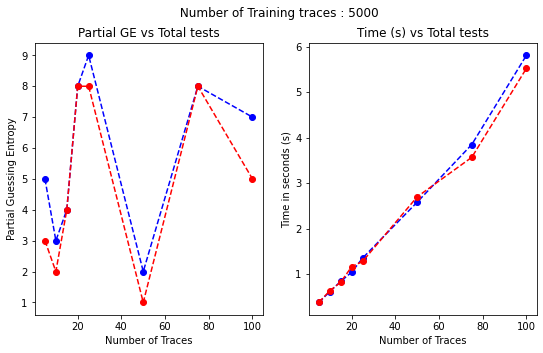

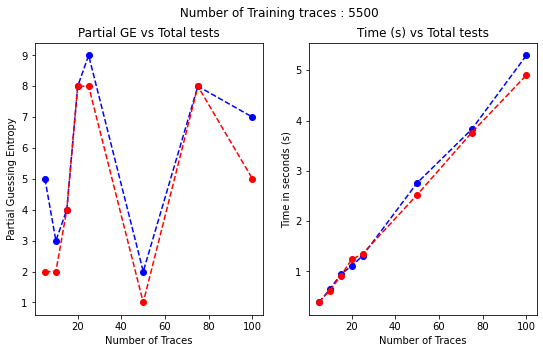

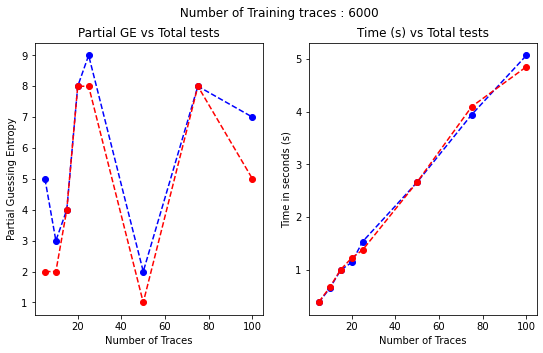

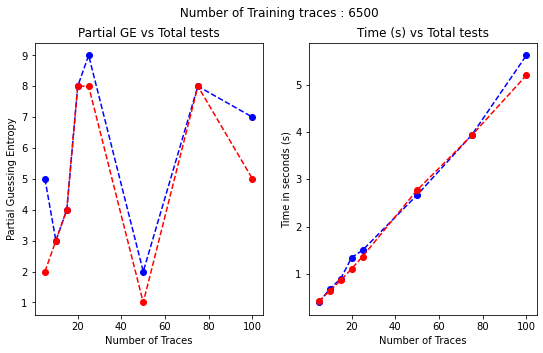

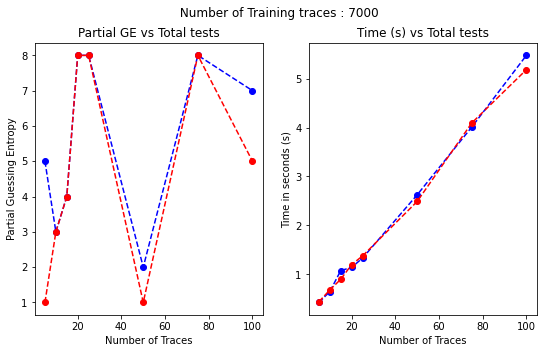

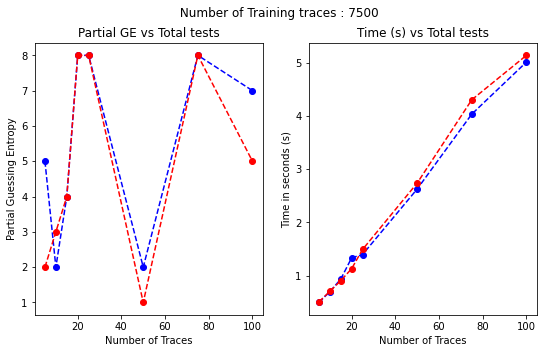

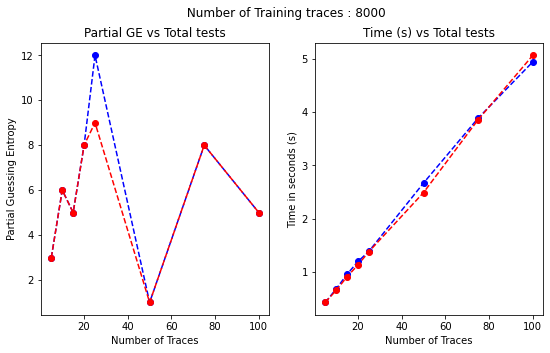

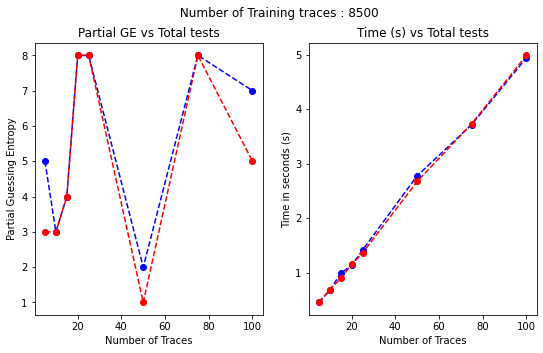

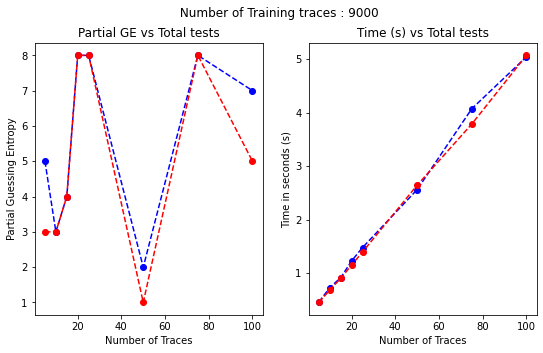

In [48]:
"""
Run Template and Pooled Template attacks on varying sizes of training and test datasets. 
"""
list_of_train_sizes = [5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000]
list_of_test_sizes = [5, 10, 15, 20, 25, 50, 75, 100]
for i in list_of_train_sizes:
    list_of_non_zero_entropy_count = []
    list_of_time = []
    pooled_list_of_time = []
    pooled_list_of_non_zero_entropy_count = []
    for j in list_of_test_sizes:

        start_time = time.time()
        pooled_list_of_non_zero_entropy_count.append(pooled_template_attack(i, j))
        pooled_list_of_time.append((time.time() - start_time))
        start_time = time.time()
        list_of_non_zero_entropy_count.append(template_attack(i, j))
        list_of_time.append((time.time() - start_time))
        
    # Create two plots one for Time and one for Partial guessing entropy
    fig, (x1,x2) = plt.subplots(1, 2, figsize=(9,5))
    fig.suptitle(f" Number of Training traces : {i}")
    x1.plot(list_of_test_sizes, list_of_non_zero_entropy_count, '--bo')
    x1.plot(list_of_test_sizes, pooled_list_of_non_zero_entropy_count , '--ro')
    x1.set_title(f"Partial GE vs Total tests")
    x1.set(xlabel='Number of Traces', ylabel='Partial Guessing Entropy')
    # plot traces vs time 
    x2.plot(list_of_test_sizes, list_of_time, '--bo')
    x2.plot(list_of_test_sizes, pooled_list_of_time, '--ro')
    x2.set_title(f"Time (s) vs Total tests")
    x2.set(xlabel='Number of Traces', ylabel='Time in seconds (s)')
    plt.show()


## Results and Analysis 

The experiments are performed for various training sizes. Each experiment is performed in increasing iterations of 500, for the various numbers of test traces. The results are plotted together. 

As observed from the experiments, the execution speed (within negligible rates) of pooled template attacks is slightly faster than that of normal template attacks. This can be attributed to the use of a single covariance matrix and the time avoided in looking up specific matrixes. 

Interestingly, the overall trend of the Partial GE against the number of traces remains consistent across the runs. With the entropy steadily decreasing with the increase in the number of traces. 

